In [2]:
!pip install xgboost
!pip install plotnine

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sys
import os
import glob
import datetime
import pickle
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from datetime import datetime
from pathlib import Path

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/services"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from sharepoint_transfer.src import main as sharepoint_transfer_svc
from data_consolidation.src import main as data_consolidation_svc
from feature_engineering.src import main as feature_engineering_svc
from model_selection.src import main as model_selection_svc
from outcome_analysis.src import main as outcome_analysis_svc
from model_training.src import main as model_training_svc
from final_fitting.src import main as final_fitting_svc
from ensemble_model.src import main as ensemble_model_svc

from model_dataset.src.main import load_dataframe
from artificial_anomaly_tests import aa_tests
from model_training import xgbr_test

## Set Measure Specific Settings

These will augment and override settings in "/root/HAIP/notebooks/services/config.json"

In [5]:
SKIP_TUNING = True
SKIP_RMSE_TEST = False
SAVE_MODEL_PICKLES = True

settings = {
    # Measure specific options
    "MEASURE_SPECIFIC_FILENAME": "OP-22.csv",
    "FULL_MEASURE_S3_PREFIX": "OP-22",
    "filter_measure": "OP_22", # make sure this is _ not -
    
    "run_save_path": "model_runs",
    "model_pickle_path": "models",
    
    # Feature Engineering options
    "backfill_prov_mean": False, # set to false to not backfill prov mean
    "backfill_lag": False, # set to false to not backfill lag
    "lag_to_add": 2, # add lag1/lag2
}

settings['save_modeling_dataset_path'] = f"/root/HAIP/data/{settings.get('MEASURE_SPECIFIC_FILENAME')}"
settings['model_dataset_path'] = settings['save_modeling_dataset_path']

## Move Sharepoint files to S3

This is not possible in SageMaker Studio because we are trying to figure out Client ID/Secret for the Sharepoint REST API. For now, run the service locally using your own Office365 username/password

## Data Consolidation

Make sure the measure `settings` are changed.


Call `data_consolidation_main.main(settings)`


This will download the full-measure-data in S3, load it into a single data frame, normalize the columns, filter to only include `filter_measure` and then upload the result to S3.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-measure-specific-data?region=us-east-1&tab=objects

In [6]:
# data_consolidation_svc.main(settings)

## Feature Engineering

Call `feature_engineering_main.main(settings)`

This will download the consolidated measure-specific-data in S3, normalize the columns, and add the new features, then upload the result to S3.
Results should also be saved locally automatically, but that is not yet implemented. For now download from the link below and upload the file to SageMaker Studio.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-modeling-dataset?region=us-east-1&tab=objects

In [7]:
# feature_engineering_svc.main(settings)

## Shift Ranges

In [8]:
sr_settings = {
    # Doesn't matter they all import modeling df the same
    # just need one for it to work
    "model_type": "XGBRegression",
}

settings = {**settings, **sr_settings}

In [9]:
sr_tuner = model_training_svc.get_model_trainer(settings)

dist_results_scatter = aa_tests.get_bootstrap_sample(
    model_data = sr_tuner.modeling_df,
    scatter = True,
    shift_n = 1000,
    shift_range = range(1,16,1)
)

dist_results_scatter = dist_results_scatter[['provider_id', 'score','mock_score', 'shift']]
dist_results_scatter

,provider_id,score,mock_score,shift
18456,420053,3.0,3.439043,1
976,100213,1.0,1.439043,1
6275,180139,6.0,6.439043,1
25144,510008,2.0,2.439043,1
13982,340075,2.0,2.439043,1
...,...,...,...,...
18654,420101,7.0,0.414351,15
10468,260195,2.0,17.000000,15
7900,220071,1.0,16.000000,15
20798,450565,1.0,7.585649,15


In [10]:
melted_dist_scatter = pd.melt(dist_results_scatter, id_vars = ['provider_id','shift'])
melted_dist_scatter.loc[melted_dist_scatter['variable'] == 'score', 'variable'] = "Original Bootstrap Sample"
melted_dist_scatter.loc[melted_dist_scatter['variable'] == 'mock_score', 'variable'] = "Artificial Anomaly"
melted_dist_scatter = melted_dist_scatter.rename(columns = {'variable': 'group','value': 'score' })
melted_dist_scatter

,provider_id,shift,group,score
0,420053,1,Original Bootstrap Sample,3.000000
1,100213,1,Original Bootstrap Sample,1.000000
2,180139,1,Original Bootstrap Sample,6.000000
3,510008,1,Original Bootstrap Sample,2.000000
4,340075,1,Original Bootstrap Sample,2.000000
...,...,...,...,...
29995,420101,15,Artificial Anomaly,0.414351
29996,260195,15,Artificial Anomaly,17.000000
29997,220071,15,Artificial Anomaly,16.000000
29998,450565,15,Artificial Anomaly,7.585649


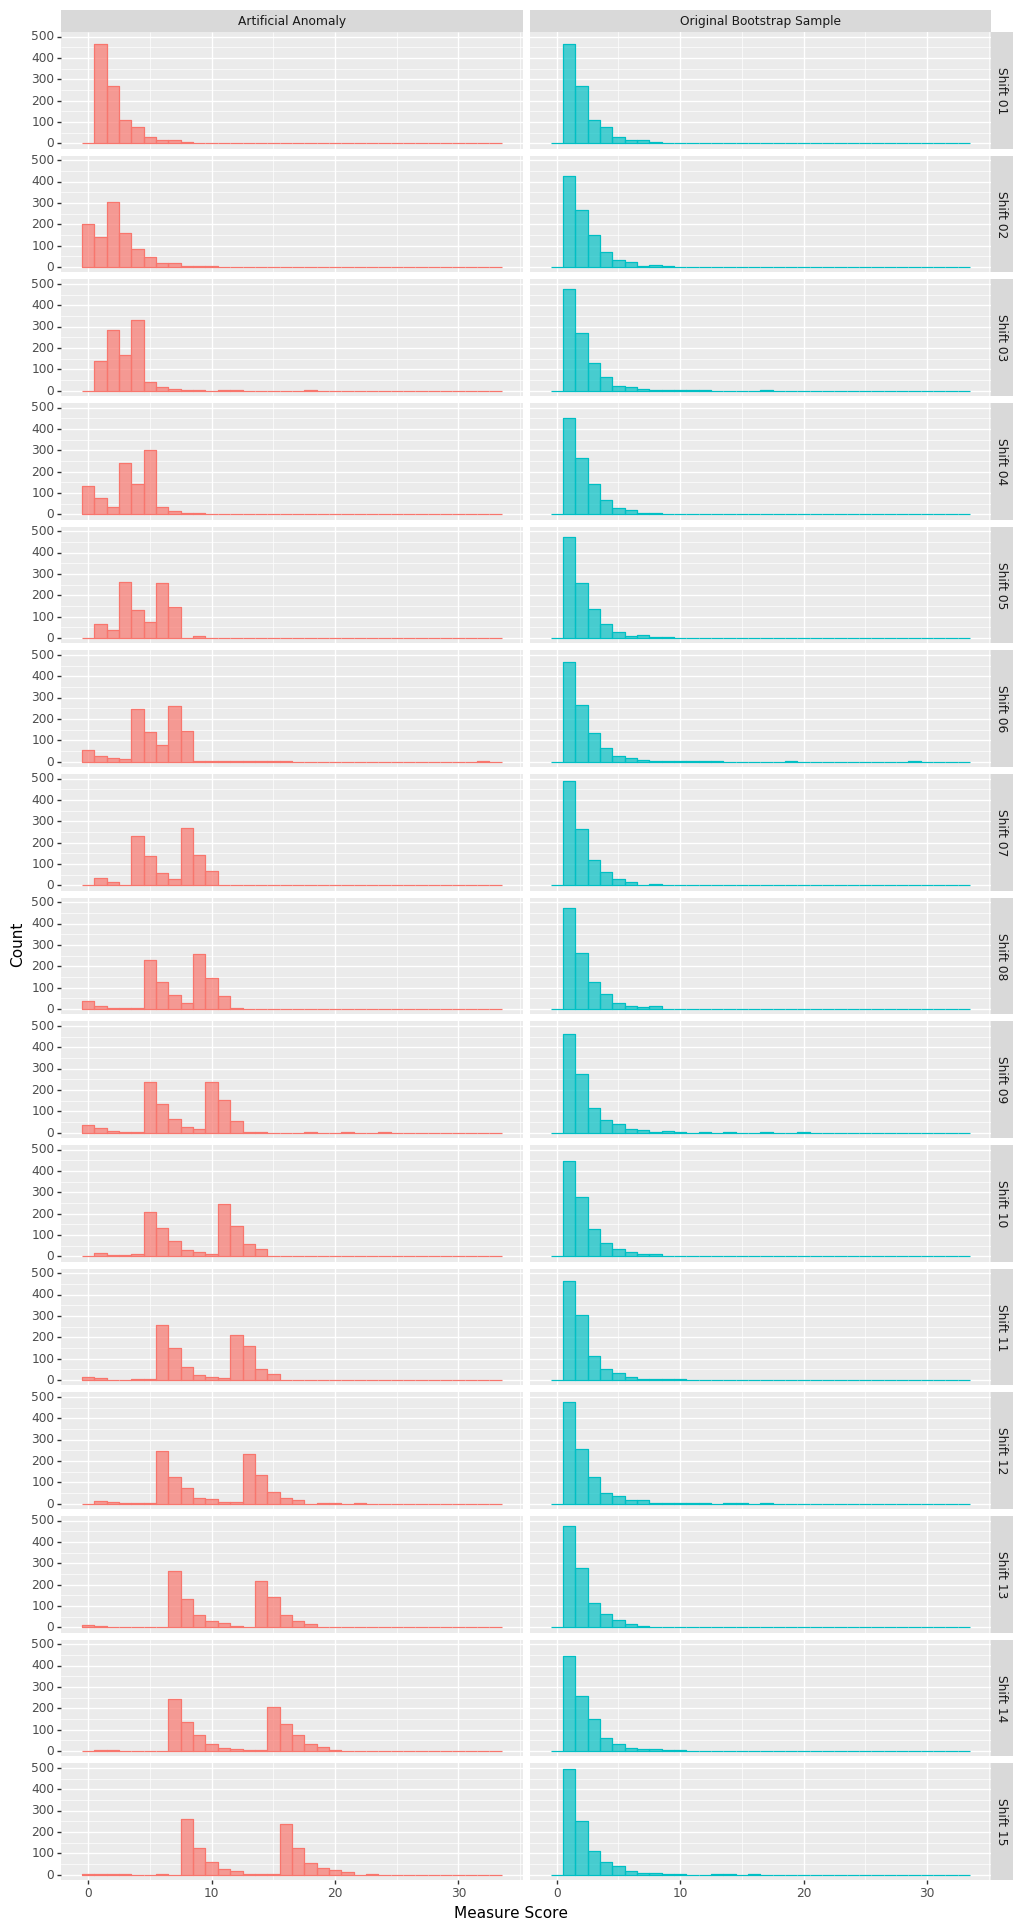

<ggplot: (8783884170997)>

In [11]:
plotnine.options.figure_size = (12,24)
graph_df = melted_dist_scatter.copy()
graph_df['shift'] = ('Shift ' + graph_df['shift'].astype(str).str.zfill(2))
(ggplot(graph_df, 
        aes(x = 'score',
            color = 'group',
            fill = 'group')
       )
 + labs(x = 'Measure Score', 
        y = 'Count',
        color = 'Group',
        fill = 'Group')
 + geom_histogram(binwidth = 1, alpha = 0.7) 
 + scale_color_manual(values = ["#F8766D", "#00BFC4"], 
                      guide = False)
 + scale_fill_manual(values = ["#F8766D", "#00BFC4"],
                     guide = False)
 + facet_grid('shift ~ group ')
)

### Selecting Shift Range

In [12]:
settings['shift_range'] = range(3, 10)

## XGBoost Regression

### Feature Importance

In [13]:
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression", 
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2]], # [[0.05, 0.1, 0.2, 0.3]]
        'gamma': [range(0, 3)],
        'max_depth': [range(3, 11)], # [range(5, 10)]
        'min_child_weight': [range(3, 11)], # [range(3, 10)]
        'subsample': [[0.7, 1]], # [[1]] #.7 does 2/3 vars each time
        'alpha': [[0, 1, 2]],
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff', 'lag2'],
}

settings = {**settings, **xgbr_feature_importance_settings}

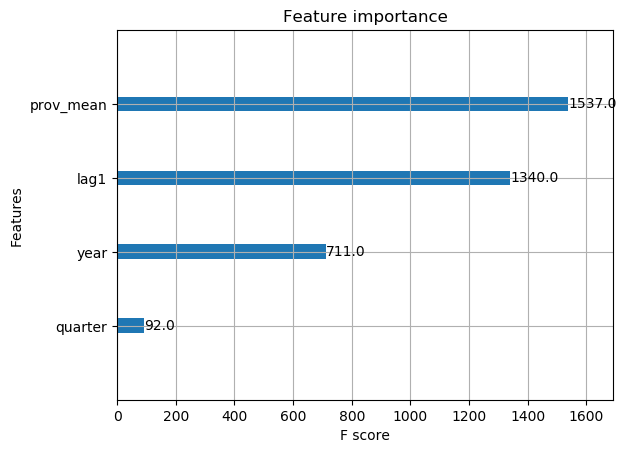

In [14]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

In [15]:
xgbr_drop_cols = ['provider_id', 'lag2', 'lag_diff', 'prov_mean_diff', 'quarter']
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression",
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_feature_importance_settings}

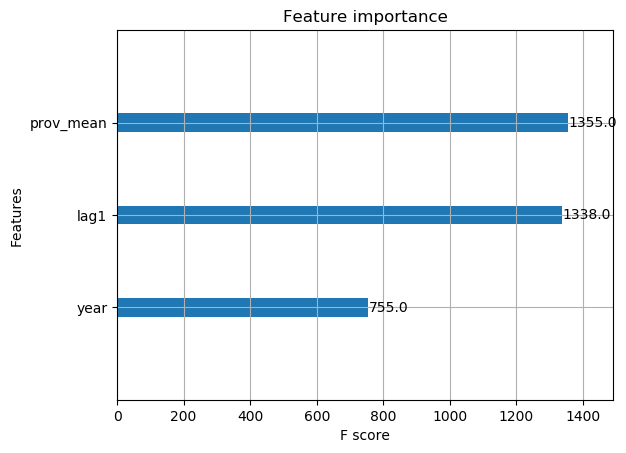

In [16]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

In [17]:
xgbr_tuner.modeling_df

,score,lag1,year,prov_mean
1,12.0,8.0,2013,8.000000
2,8.0,12.0,2014,10.000000
3,8.0,8.0,2014,9.333333
4,6.0,8.0,2015,9.000000
5,5.0,6.0,2016,8.400000
...,...,...,...,...
26859,4.0,3.0,2015,2.500000
26860,6.0,4.0,2016,2.800000
26861,3.0,6.0,2017,3.333333
26862,4.0,3.0,2018,3.285714


### Tuning

In [18]:
candidate = None
if not SKIP_TUNING:
    candidate = xgbr_tuner.tune()

In [19]:
candidate

### Model Selection

Make sure `model_run_data_path` is set in settings to the tuning result path.
Make sure `model_type` is set in settings to `XGBRegression`, `Isolation Forest`, or `Ensemble`

Call `model_selector = model_selection_main.get_model_selector(settings)` to get the appropriate selector.
Then call `model_selector.get_top_models()` to get the top models

To get the candidate model that matches one of the top_model:
     Call `model_selector.get_candidate_model_by_index(INDEX)` to get the candidate model
     Call `model_selector.get_candidate_model_params_by_index(INDEX)` to get the candidate model params

For `model_run_data_path` right click the file in side nav and choose `Copy Path`. Paste that and add a `/root/` before it.

In [20]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgboost_regression/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgboost_regression/tuning_results_run_2022-12-02-14h43m.csv


In [21]:
xgbr_model_selector = model_selection_svc.get_model_selector(settings)
xgbr_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
1892,-1.5081,0.2438,1,1,0.10,2,9,5,0.7,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."
3044,-1.5085,0.2400,2,2,0.10,2,9,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 2, 'max_dept..."
2932,-1.5088,0.2433,3,2,0.10,1,10,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
2788,-1.5089,0.2414,4,2,0.10,0,9,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."
2804,-1.5093,0.2420,5,2,0.10,0,10,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."
2916,-1.5095,0.2410,6,2,0.10,1,9,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
2377,-1.5101,0.2473,7,2,0.05,0,7,7,1.0,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
3060,-1.5106,0.2412,8,2,0.10,2,10,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 2, 'max_dept..."
2649,-1.5110,0.2466,9,2,0.05,2,8,7,1.0,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
1908,-1.5112,0.2426,10,1,0.10,2,10,5,0.7,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."


In [22]:
xgbr_model_index = 2649
# xgbr_model_index = xgbr_model_selector.get_top_models().iloc[0].name # default top model
xgbr_model_selector.get_candidate_model_by_index(xgbr_model_index)

mean_fit_time         1.7049
std_fit_time          0.5212
mean_score_time        0.021
std_score_time        0.0043
param_alpha                2
                       ...  
split48_test_score   -1.5442
split49_test_score   -1.7672
mean_test_score       -1.511
std_test_score        0.2466
rank_test_score            9
Name: 2649, Length: 64, dtype: object

In [23]:
xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index)

{'alpha': 2,
 'eta': 0.05,
 'gamma': 2,
 'max_depth': 8,
 'min_child_weight': 7,
 'subsample': 1}

### Final Fit

In [24]:
xgbr_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index),
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_final_fit_settings}

In [25]:
xgbr_fitter = final_fitting_svc.get_final_fitter(settings)
xgbr_model = xgbr_fitter.fit()

In [26]:
xgbr_model

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [27]:
xgbr_selected_features = list(xgbr_fitter.modeling_df.columns)
xgbr_selected_features.remove('score')
xgbr_selected_features

['lag1', 'year', 'prov_mean']

In [28]:
threshold_range = range(1,100)

xgbr_aat_res = aa_tests.artificial_anomaly_test_xgb(
    model = xgbr_model, 
    model_data = xgbr_fitter.modeling_df,
    selected_features = xgbr_selected_features,
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)[:5]

xgbr_threshold = xgbr_aat_res.iloc[0]['Threshold']
print("Using Threshold", xgbr_threshold)

xgbr_aat_res

Using Threshold 2.0


,Threshold,AUROC
1,2,0.894643
0,1,0.884357
2,3,0.821143
3,4,0.740429
4,5,0.659143


### CV RMSE

In [29]:
xgbr_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, xgbr_cv_rmse = xgbr_test.test_xgbr(xgbr_fitter.modeling_df)
xgbr_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.0s finished


1.811659451697596

### Save Model Pickle

In [30]:
if SAVE_MODEL_PICKLES:
    to_save = {
        'model':xgbr_model, 
        'threshold': xgbr_threshold, 
        'cv_rmse': xgbr_cv_rmse,
        'selected_features': xgbr_selected_features,
        'drop_cols': xgbr_drop_cols
    }
    model_pickle_path = settings.get('model_pickle_path')
    current_date = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
    
    path = f"{model_pickle_path}/xgboost_regression/model_info_{current_date}.p"
    Path(f"{model_pickle_path}/xgboost_regression").mkdir(parents=True, exist_ok=True)

    with open(path, 'wb') as handle:
        print(f"Saving {path}")
        pickle.dump(to_save, handle)

Saving models/xgboost_regression/model_info_2022-12-07-19h53m.p


## Isolation Forest

### Tuning

In [31]:
if_drop_cols = ['provider_id', 'lag2', 'year', 'quarter']
if_training_settings = {
    "model_type": "Isolation Forest", 
    "if_parameters": {
        # Features to include
        'features_included': [['lag_diff', 'prov_mean_diff']],
        # The number of base estimators in the ensemble.
        'n_estimators': [50, 75, 100, 150, 200, 300],
        # The number of samples to draw from X to train each base estimator.
        'max_samples': [512, 'auto', 200, 175, 128, 64],
        # The number of features to draw from X to train each base estimator.
        'max_features': [0.5, 1],
        # If True, individual trees are fit on random subsets of the training data sampled with replacement.
        # If False, sampling without replacement is performed.
        'bootstrap': [False, True]
    },
    "drop_cols": if_drop_cols, # use just lag1, prov_mean
}

settings = {**settings, **if_training_settings}

In [32]:
if_trainer = model_training_svc.get_model_trainer(settings)

In [33]:
if_trainer.modeling_df

,score,lag1,lag_diff,prov_mean,prov_mean_diff
1,12.0,8.0,4.0,8.000000,4.000000
2,8.0,12.0,-4.0,10.000000,-2.000000
3,8.0,8.0,0.0,9.333333,-1.333333
4,6.0,8.0,-2.0,9.000000,-3.000000
5,5.0,6.0,-1.0,8.400000,-3.400000
...,...,...,...,...,...
26859,4.0,3.0,1.0,2.500000,1.500000
26860,6.0,4.0,2.0,2.800000,3.200000
26861,3.0,6.0,-3.0,3.333333,-0.333333
26862,4.0,3.0,1.0,3.285714,0.714286


In [34]:
candidate = None
if not SKIP_TUNING:
    candidate = if_trainer.tune()

In [35]:
candidate

### Model Selection

In [36]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/isolation_forest/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

if_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "Isolation Forest"
}

settings = {**settings, **if_settings}

Using result:  model_runs/isolation_forest/tuning_results_run_2022-12-05-20h30m.csv


In [37]:
if_model_selector = model_selection_svc.get_model_selector(settings)
if_model_selector.get_top_models()

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
36,False,"[lag_diff, prov_mean_diff]",1.0,512,50,37,0.9666,0.9068,0.9129,0.9093,0.9115,0.8968,0.8951,0.8906,0.8850,0.8831,0.8675,0.8631,0.8579,0.8521,0.8382,0.8223,0.8178
0,False,"[lag_diff, prov_mean_diff]",0.5,512,50,1,0.9662,0.9072,0.9132,0.9094,0.9115,0.8972,0.8957,0.8906,0.8850,0.8835,0.8678,0.8638,0.8581,0.8520,0.8381,0.8223,0.8175
2,False,"[lag_diff, prov_mean_diff]",0.5,512,100,3,0.9658,0.9115,0.9112,0.9057,0.8998,0.8949,0.8908,0.8864,0.8724,0.8718,0.8653,0.8610,0.8541,0.8499,0.8252,0.8206,0.8139
38,False,"[lag_diff, prov_mean_diff]",1.0,512,100,39,0.9658,0.9115,0.9112,0.9057,0.8998,0.8949,0.8908,0.8864,0.8724,0.8718,0.8653,0.8610,0.8541,0.8499,0.8252,0.8206,0.8139
1,False,"[lag_diff, prov_mean_diff]",0.5,512,75,2,0.9657,0.9099,0.9103,0.9080,0.8965,0.8951,0.8891,0.8861,0.8723,0.8710,0.8649,0.8591,0.8539,0.8494,0.8237,0.8199,0.8139
37,False,"[lag_diff, prov_mean_diff]",1.0,512,75,38,0.9657,0.9099,0.9103,0.9080,0.8965,0.8951,0.8891,0.8861,0.8723,0.8710,0.8649,0.8591,0.8539,0.8494,0.8237,0.8199,0.8139
3,False,"[lag_diff, prov_mean_diff]",0.5,512,150,4,0.9656,0.9126,0.9083,0.9053,0.8999,0.8962,0.8924,0.8877,0.8854,0.8718,0.8669,0.8633,0.8560,0.8515,0.8261,0.8217,0.8145
39,False,"[lag_diff, prov_mean_diff]",1.0,512,150,40,0.9656,0.9126,0.9083,0.9053,0.8999,0.8962,0.8924,0.8877,0.8854,0.8718,0.8669,0.8633,0.8560,0.8515,0.8261,0.8217,0.8145
5,False,"[lag_diff, prov_mean_diff]",0.5,512,300,6,0.9655,0.9119,0.9080,0.9061,0.8991,0.8965,0.8931,0.8882,0.8845,0.8717,0.8698,0.8636,0.8583,0.8521,0.8265,0.8224,0.8147
41,False,"[lag_diff, prov_mean_diff]",1.0,512,300,42,0.9655,0.9119,0.9080,0.9061,0.8991,0.8965,0.8931,0.8882,0.8845,0.8717,0.8698,0.8636,0.8583,0.8521,0.8265,0.8224,0.8147


In [38]:
if_model_id = 1
# if_model_id = if_model_selector.get_top_models().iloc[0].model_id # default top model
if_model_selector.get_candidate_model_by_index(if_model_id)

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
0,False,"[lag_diff, prov_mean_diff]",0.5,512,50,1,0.9662,0.9072,0.9132,0.9094,0.9115,0.8972,0.8957,0.8906,0.885,0.8835,0.8678,0.8638,0.8581,0.852,0.8381,0.8223,0.8175


In [39]:
if_model_selector.get_candidate_model_params_by_index(if_model_id)

{'bootstrap': False,
 'features_included': ['lag_diff', 'prov_mean_diff'],
 'max_features': 0.5,
 'max_samples': 512,
 'n_estimators': 50}

### Final Fit

In [40]:
if_final_fit_settings = {
    "model_type": "Isolation Forest",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "if_final_params": if_model_selector.get_candidate_model_params_by_index(if_model_id),
    "drop_cols": if_drop_cols,
}

del if_final_fit_settings['if_final_params']['features_included']

settings = {**settings, **if_final_fit_settings}

In [41]:
if_fitter = final_fitting_svc.get_final_fitter(settings)
if_model = if_fitter.fit()

In [42]:
if_model

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=0.5, max_samples=512, n_estimators=50, n_jobs=-1,
                random_state=RandomState(MT19937) at 0x7FD284C7A6B0, verbose=0,
                warm_start=False)

In [43]:
if_anomaly_scores = if_fitter.get_anomaly_scores()
if_anomaly_scores

array([0.68042972, 0.71331022, 0.61290382, ..., 0.55717107, 0.46474773,
       0.49627371])

### Threshold

In [44]:
_candidate = if_model_selector.get_candidate_model_by_index(if_model_id)
_candidate = _candidate.drop(columns=[col for col in _candidate.columns if 'auroc_threshold_' not in col])

highest_auroc = _candidate.max().max()
threshold_col_name = None
for col in _candidate.columns:
    if _candidate[col].item() == highest_auroc:
        threshold_col_name = col
        break

if threshold_col_name is None:
    print("Could not find threshold for Isolation Forest")
else:
    if_threshold = float(threshold_col_name.replace('auroc_threshold_', ''))
    print("Using threshold", if_threshold, "based on highest value", highest_auroc)

Using threshold 0.51 based on highest value 0.9132


In [45]:
# if_threshold = 0.56

### Save Model Pickle

In [46]:
if SAVE_MODEL_PICKLES:
    to_save = {
        'model':if_model, 
        'threshold': if_threshold, 
        'if_anomaly_scores': if_anomaly_scores,
        'drop_cols': if_drop_cols
    }
    model_pickle_path = settings.get('model_pickle_path')
    current_date = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
    
    path = f"{model_pickle_path}/isolation_forest/model_info_{current_date}.p"
    Path(f"{model_pickle_path}/isolation_forest").mkdir(parents=True, exist_ok=True)

    with open(path, 'wb') as handle:
        print(f"Saving {path}")
        pickle.dump(to_save, handle)

Saving models/isolation_forest/model_info_2022-12-07-19h53m.p


## Ensemble Model

### Feature Importance

In [47]:
ensemble_settings = {
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2]], # [[0.05, 0.1, 0.2, 0.3]]
        'gamma': [range(0, 3)],
        'max_depth': [range(3, 11)], # [range(5, 10)]
        'min_child_weight': [range(3, 11)], # [range(3, 10)]
        'subsample': [[0.7, 1]], # [[1]] #.7 does 2/3 vars each time
        'alpha': [[0, 1, 2]],
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff', 'lag2'],
    "if_model": if_model,
    "if_anomaly_scores": if_anomaly_scores,
}

settings = {**settings, **ensemble_settings}

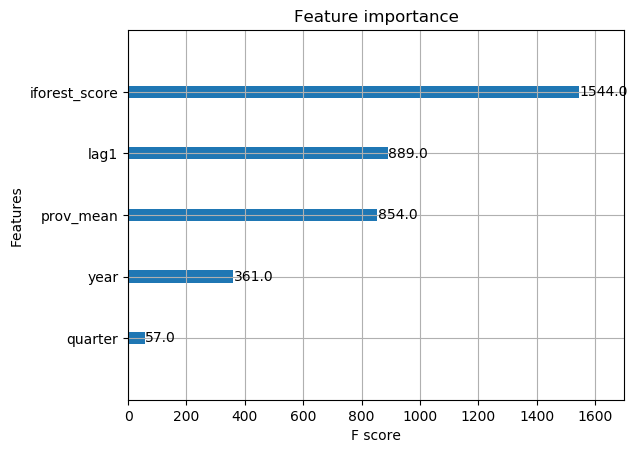

In [48]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

In [49]:
ensemble_drop_cols = ['provider_id', 'lag2', 'prov_mean_diff', 'year', 'quarter', 'lag_diff']
ensemble_settings = {
    "drop_cols": ensemble_drop_cols
}

settings = {**settings, **ensemble_settings}

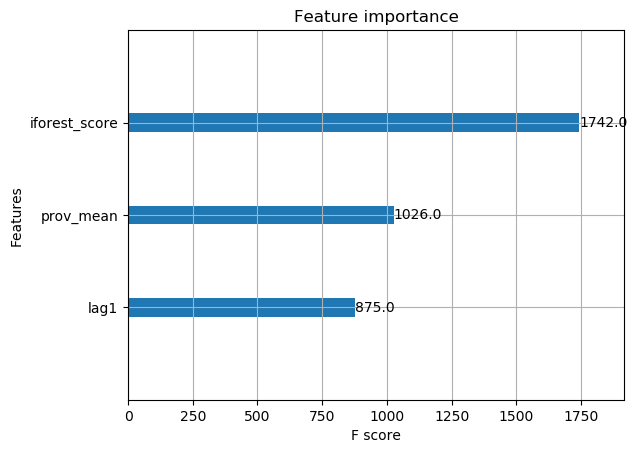

In [50]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

In [51]:
ensemble_trainer.modeling_df

,score,lag1,prov_mean,iforest_score
1,12.0,8.0,8.000000,0.680430
2,8.0,12.0,10.000000,0.713310
3,8.0,8.0,9.333333,0.612904
4,6.0,8.0,9.000000,0.608268
5,5.0,6.0,8.400000,0.577774
...,...,...,...,...
26859,4.0,3.0,2.500000,0.462045
26860,6.0,4.0,2.800000,0.576382
26861,3.0,6.0,3.333333,0.557171
26862,4.0,3.0,3.285714,0.464748


### Tuning

In [52]:
candidate = None
if not SKIP_TUNING:
    candidate = ensemble_trainer.tune()

In [53]:
candidate

In [54]:
ensemble_trainer.modeling_df

,score,lag1,prov_mean,iforest_score
1,12.0,8.0,8.000000,0.680430
2,8.0,12.0,10.000000,0.713310
3,8.0,8.0,9.333333,0.612904
4,6.0,8.0,9.000000,0.608268
5,5.0,6.0,8.400000,0.577774
...,...,...,...,...
26859,4.0,3.0,2.500000,0.462045
26860,6.0,4.0,2.800000,0.576382
26861,3.0,6.0,3.333333,0.557171
26862,4.0,3.0,3.285714,0.464748


### Model Selection

In [55]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgbr_ensemble/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgbr_ensemble/tuning_results_run_2022-12-05-21h08m.csv


In [56]:
ensemble_model_selector = model_selection_svc.get_model_selector(settings)
ensemble_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
2039,-1.0337,0.3117,1,1,0.20,0,10,6,1.0,"{'alpha': 1, 'eta': 0.2, 'gamma': 0, 'max_dept..."
1271,-1.0357,0.3097,2,1,0.05,0,10,6,1.0,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
503,-1.0368,0.3069,3,0,0.10,0,10,6,1.0,"{'alpha': 0, 'eta': 0.1, 'gamma': 0, 'max_dept..."
1655,-1.0375,0.3157,4,1,0.10,0,10,6,1.0,"{'alpha': 1, 'eta': 0.1, 'gamma': 0, 'max_dept..."
2935,-1.0382,0.3124,6,2,0.10,1,10,6,1.0,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
631,-1.0382,0.3129,5,0,0.10,1,10,6,1.0,"{'alpha': 0, 'eta': 0.1, 'gamma': 1, 'max_dept..."
2423,-1.0389,0.3161,7,2,0.05,0,10,6,1.0,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
1399,-1.0398,0.3168,8,1,0.05,1,10,6,1.0,"{'alpha': 1, 'eta': 0.05, 'gamma': 1, 'max_dep..."
1911,-1.0401,0.3162,9,1,0.10,2,10,6,1.0,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."
2807,-1.0405,0.3154,10,2,0.10,0,10,6,1.0,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."


In [57]:
ensemble_model_index = 2935
# ensemble_model_index = ensemble_model_selector.get_top_models().iloc[0].name # default top model
ensemble_model_selector.get_candidate_model_by_index(ensemble_model_index)

mean_fit_time          2.129
std_fit_time          0.8907
mean_score_time       0.0247
std_score_time         0.008
param_alpha                2
                       ...  
split48_test_score   -1.0022
split49_test_score    -1.191
mean_test_score      -1.0382
std_test_score        0.3124
rank_test_score            6
Name: 2935, Length: 64, dtype: object

In [58]:
ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index)

{'alpha': 2,
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 10,
 'min_child_weight': 6,
 'subsample': 1}

### Final Fit

In [59]:
ensemble_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index),
    "drop_cols": ensemble_drop_cols,
}

settings = {**settings, **ensemble_final_fit_settings}

In [60]:
ensemble_fitter = ensemble_model_svc.get_ensemble_final_fitter(settings)
ensemble_model = ensemble_fitter.fit()

In [61]:
ensemble_fitter.modeling_df

,score,lag1,prov_mean,iforest_score
1,12.0,8.0,8.000000,0.680430
2,8.0,12.0,10.000000,0.713310
3,8.0,8.0,9.333333,0.612904
4,6.0,8.0,9.000000,0.608268
5,5.0,6.0,8.400000,0.577774
...,...,...,...,...
26859,4.0,3.0,2.500000,0.462045
26860,6.0,4.0,2.800000,0.576382
26861,3.0,6.0,3.333333,0.557171
26862,4.0,3.0,3.285714,0.464748


In [62]:
ensemble_model

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [63]:
ensemble_selected_features = list(ensemble_fitter.modeling_df.columns)
ensemble_selected_features.remove('score')
ensemble_selected_features

['lag1', 'prov_mean', 'iforest_score']

In [64]:
# threshold_range = range(1, 100)
threshold_range = np.arange(0.5, 20, 0.5)

ensemble_aat_res = aa_tests.artificial_anomaly_test_xgb(
    model = ensemble_model,
    model_data = ensemble_fitter.modeling_df,
    selected_features = ensemble_selected_features,
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)[:10]

ensemble_threshold = ensemble_aat_res.iloc[0]['Threshold']
print("Using Threshold", ensemble_threshold)

ensemble_aat_res

Using Threshold 1.5


,Threshold,AUROC
2,1.5,0.977929
1,1.0,0.975929
0,0.5,0.948714
3,2.0,0.930714
4,2.5,0.892929
5,3.0,0.833071
6,3.5,0.794429
7,4.0,0.741571
8,4.5,0.701286
9,5.0,0.656071


In [65]:
# ensemble_aat_res = 2

### CV RMSE

In [66]:
ensemble_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, ensemble_cv_rmse = xgbr_test.test_xgbr(ensemble_fitter.modeling_df)
ensemble_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.7s finished


1.3274665970111843

### Save Model Pickle

In [67]:
if SAVE_MODEL_PICKLES:
    to_save = {
        'model':ensemble_model, 
        'threshold': ensemble_threshold, 
        'cv_rmse': ensemble_cv_rmse,
        'selected_features': ensemble_selected_features,
        'drop_cols': ensemble_drop_cols
    }
    model_pickle_path = settings.get('model_pickle_path')
    current_date = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")

    path = f"{model_pickle_path}/ensemble_model/model_info_{current_date}.p"
    Path(f"{model_pickle_path}/ensemble_model").mkdir(parents=True, exist_ok=True)

    with open(path, 'wb') as handle:
        print(f"Saving {path}")
        pickle.dump(to_save, handle)

Saving models/ensemble_model/model_info_2022-12-07-19h54m.p
